# This notebook is a continuation of the classification exercises notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
import acquire
import prepare

In [2]:
raw_telco_df = acquire.get_telco_data()
raw_telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [3]:
raw_telco_df.shape

(7043, 24)

In [4]:
raw_telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
raw_telco_df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


# I utilized my prep_telco and split_telco_data functions from prepare.py to get the data ready

### Remember how we call functions from file please

In [6]:
# take note of how we had to call the prepare.py file here
telco_prepped = prepare.prep_telco(raw_telco_df)

In [7]:
telco_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7043 non-null   object 
 1   gender                                 7043 non-null   object 
 2   senior_citizen                         7043 non-null   int64  
 3   partner                                7043 non-null   object 
 4   dependents                             7043 non-null   object 
 5   tenure                                 7043 non-null   int64  
 6   phone_service                          7043 non-null   object 
 7   multiple_lines                         7043 non-null   object 
 8   online_security                        7043 non-null   object 
 9   online_backup                          7043 non-null   object 
 10  device_protection                      7043 non-null   object 
 11  tech

In [8]:
#here, we reassign the three values returned from the split_data function to new variables
telco_train, telco_validate, telco_test = prepare.split_telco_data(telco_prepped)
print(f'telco_train: {telco_train.shape}')
print(f'telco_validate: {telco_validate.shape}')
print(f'telco_test: {telco_test.shape}')

telco_train: (3943, 48)
telco_validate: (1691, 48)
telco_test: (1409, 48)


# At this point, we now have our train, validate, test data sets

In [16]:
telco_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 592 to 1485
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            3943 non-null   object 
 1   gender                                 3943 non-null   object 
 2   senior_citizen                         3943 non-null   int64  
 3   partner                                3943 non-null   object 
 4   dependents                             3943 non-null   object 
 5   tenure                                 3943 non-null   int64  
 6   phone_service                          3943 non-null   object 
 7   multiple_lines                         3943 non-null   object 
 8   online_security                        3943 non-null   object 
 9   online_backup                          3943 non-null   object 
 10  device_protection                      3943 non-null   object 
 11  te

In [17]:
telco_train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,3943.0,0.161299,0.367853,0.00,0.000,0.00,0.00,1.00
tenure,3943.0,32.260462,24.737431,0.00,8.000,29.00,56.00,72.00
monthly_charges,3943.0,64.343127,30.115024,18.25,35.075,70.20,89.70,118.75
total_charges,3943.0,2262.584479,2274.727271,0.00,385.725,1359.45,3762.05,8672.45
gender_Male,3943.0,0.496323,0.500050,0.00,0.000,0.00,1.00,1.00
partner_Yes,3943.0,0.473244,0.499347,0.00,0.000,0.00,1.00,1.00
dependents_Yes,3943.0,0.296728,0.456874,0.00,0.000,0.00,1.00,1.00
phone_service_Yes,3943.0,0.905402,0.292696,0.00,1.000,1.00,1.00,1.00
multiple_lines_No phone service,3943.0,0.094598,0.292696,0.00,0.000,0.00,0.00,1.00
multiple_lines_Yes,3943.0,0.423028,0.494102,0.00,0.000,0.00,1.00,1.00


# Univariate analysis:

In [18]:
# this cell is isolating the number format columns for analysis below

num_cols = telco_train.columns[[telco_train[col].dtype in ('int64', 'float64') for col in telco_train.columns]]
num_cols

Index(['senior_citizen', 'tenure', 'monthly_charges', 'total_charges'], dtype='object')

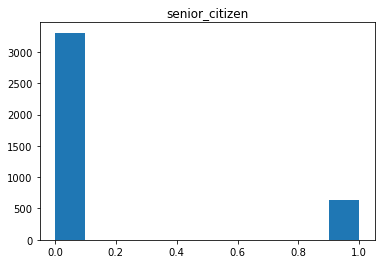

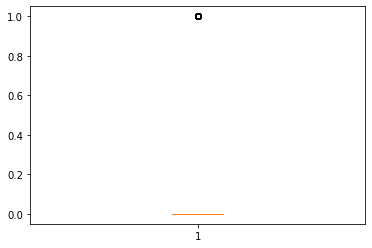

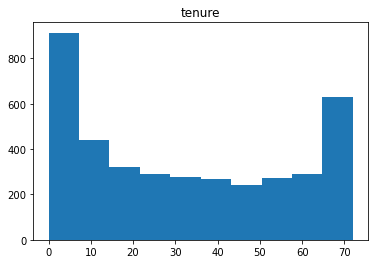

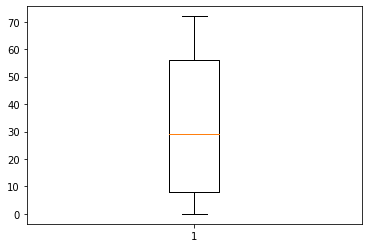

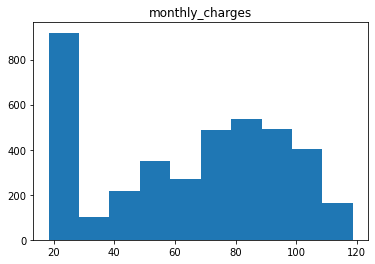

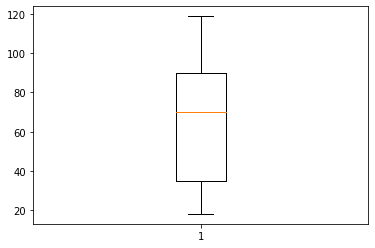

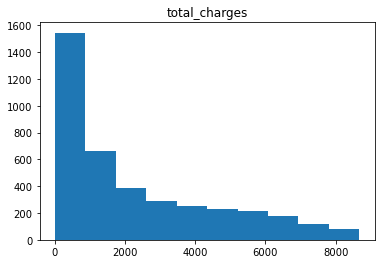

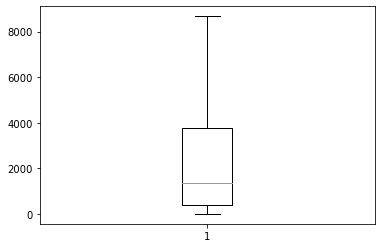

In [19]:
# this cell is giving me a histogram and boxplot for all numerical data.  

for col in num_cols:
    plt.hist(telco_train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(telco_train[col])
    plt.show()

In [20]:
# this cell is isolating the columns with an object ('O') type for analysis

obj_cols = telco_train.columns[[telco_train[col].dtype == 'O' for col in telco_train.columns]]
obj_cols

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [21]:
# and here, we get an idea of what each object feature contains

for col in obj_cols:
    print(telco_train[col].value_counts())
    print(telco_train[col].value_counts(normalize = True, dropna=False))
    print('------------------------')

0289-IVARM    1
5502-RLUYV    1
5999-LCXAO    1
9462-MJUAW    1
5639-NTUPK    1
             ..
9777-WJJPR    1
6557-BZXLQ    1
7244-QWYHG    1
0203-HHYIJ    1
4452-ROHMO    1
Name: customer_id, Length: 3943, dtype: int64
0289-IVARM    0.000254
5502-RLUYV    0.000254
5999-LCXAO    0.000254
9462-MJUAW    0.000254
5639-NTUPK    0.000254
                ...   
9777-WJJPR    0.000254
6557-BZXLQ    0.000254
7244-QWYHG    0.000254
0203-HHYIJ    0.000254
4452-ROHMO    0.000254
Name: customer_id, Length: 3943, dtype: float64
------------------------
Female    1986
Male      1957
Name: gender, dtype: int64
Female    0.503677
Male      0.496323
Name: gender, dtype: float64
------------------------
No     2077
Yes    1866
Name: partner, dtype: int64
No     0.526756
Yes    0.473244
Name: partner, dtype: float64
------------------------
No     2773
Yes    1170
Name: dependents, dtype: int64
No     0.703272
Yes    0.296728
Name: dependents, dtype: float64
------------------------
Yes    3570
No     

In [22]:
telco_train.monthly_charges.value_counts(bins=5, sort=False)

(18.148999999999997, 38.35]    1022
(38.35, 58.45]                  568
(58.45, 78.55]                  759
(78.55, 98.65]                 1031
(98.65, 118.75]                 563
Name: monthly_charges, dtype: int64